<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
<br />
Егор, доброго дня! рад приветствовать тебя в финале) <br />
Вот и он подобрался, поздравляю. Остался последний рывок в этом марафоне)<br>
<br />
Меня зовут Николай. <br />И на этом этапе Вашего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='purple'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако что есть ещё что-то или в коде или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Как и всегда в спринтах - ставлю своей целью максимально помочь. Поэтому, все мои комментарии - это только способ передать свой опыт для помощи в твоих достижениях.

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import numpy as np
from dython.nominal import associations

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter('ignore')

In [89]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Исследовательский анализ данных

Для определения дальнейшего плана действий изучим каждый датасет.

### Contract

In [90]:
contract.info()
display(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


Из первичной информации можно сделать следующие выводы:
1. Тип данных некоторых столбцов не соответствует ожидаемым (например, у столбца BeginDate тип данных "object", хотя должен быть datetime; столбцы MonthlyCharges и TotalCharges должны быть типа float). Также, вызывает вопросы столбец EndDate, где сочетаются категориальные данные и временные. Возможен перевод временных данных в категориальную и, как следствие, перевод столбца в бинарную переменную с типом данных int, где 0 - действующий клиент, 1 - клиент ушел.
2. Пропусков не замечено

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ок.

In [91]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y-%m-%d')
#столбец BeginDate перевед в тип данных datetime64

contract['MonthlyCharges'] = pd.to_numeric(contract['MonthlyCharges'], errors = 'coerce')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


После изменения типа данных появились пропуски в TotalCharges

In [92]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [93]:
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = contract[contract['TotalCharges'].isna()]['MonthlyCharges']

Все клиенты, у кого присутствуют пропуски в столбце TotalCharges стали пользоваться услугами данной телеком компании в одно и то же время 2020-02-01. Можно предположить, что поскольку датой выгрузки как раз и является 1 февраля 2020 года, то информация о данных клиентах просто не успела обработаться. Поскольу договор уже заключен и оплата за первый месяц была совершена, то можно предположить, что общий доход с каждого клиента равен его месячному платежу.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>точно, новички)

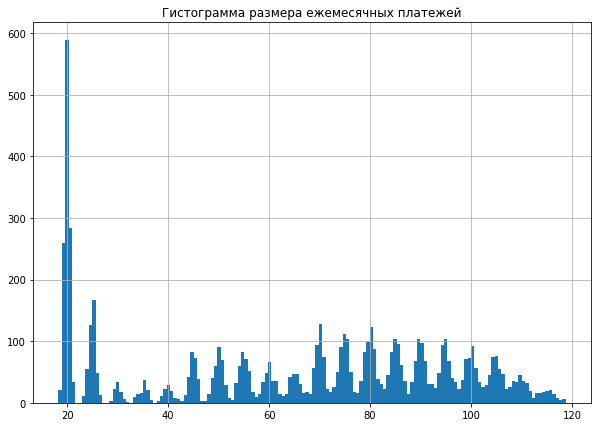

In [94]:
contract['MonthlyCharges'].hist(bins = 150, figsize = (10, 7))
plt.title('Гистограмма размера ежемесячных платежей')
plt.show()

In [95]:
contract['MonthlyCharges'].value_counts().head(50)

20.05    61
19.85    45
19.95    44
19.90    44
20.00    43
19.70    43
19.65    43
19.55    40
20.15    40
19.75    39
20.25    39
20.35    38
19.80    38
19.60    37
20.10    37
20.20    35
19.50    32
19.40    31
20.45    31
20.40    30
19.45    28
20.50    28
20.30    28
20.55    27
19.35    25
19.30    24
20.65    23
25.25    20
25.10    19
19.25    18
25.00    17
19.20    17
20.75    17
84.80    17
74.40    16
81.00    15
20.85    15
24.45    15
24.80    15
20.60    15
79.85    14
70.15    14
80.45    14
79.20    14
25.05    14
25.15    14
89.85    13
20.70    13
80.85    13
95.00    13
Name: MonthlyCharges, dtype: int64

При изучении гистограммы размера ежемесячных платежей можно заметить следующее:
1. Наиболее распространенный ежемесячный платже составляет приблизительно 20 у.е.
2. Заметны явные пики на кадом "круглой цифре". 20, 25, 30, 35, 40 и т.д. При этом в окрестностях каждого такого "круглого" размеры платежей распределены нормально. Можно сказать, что мы имеем множество нормальных распределений на каждом числе, которое заканчивается на 5 или 0.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ещё, гистограмма 'MonthlyCharges' показывает бимодальность - несколько горбов) Это говорит о том, что в самой выборке есть несколько однородных выборок. Здесь, может быть, это завязано на количество услуг, или "болатый/бедный" клиент. В общем - можно попробовать выделить ещё фактор, который как раз объясняет эту бимодальность.

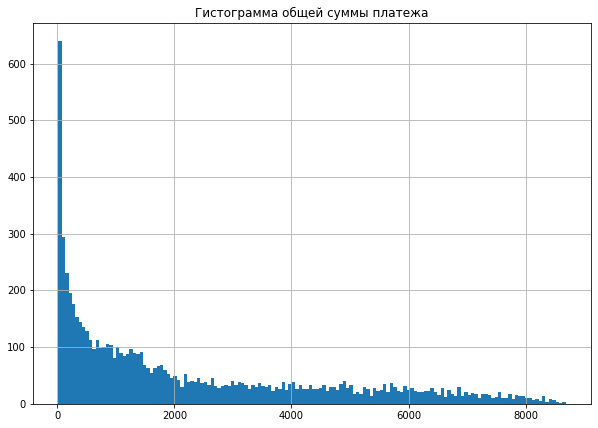

In [96]:
contract['TotalCharges'].hist(bins = 150, figsize = (10, 7))
plt.title('Гистограмма общей суммы платежа')
plt.show()

Большая часть клиентов имеют суммарный платеж не более 100 у.е. Причиной такого может быть большое количество новых клиентов, например. Исследуем далее время прихода клиентов для дачи более точной причины.

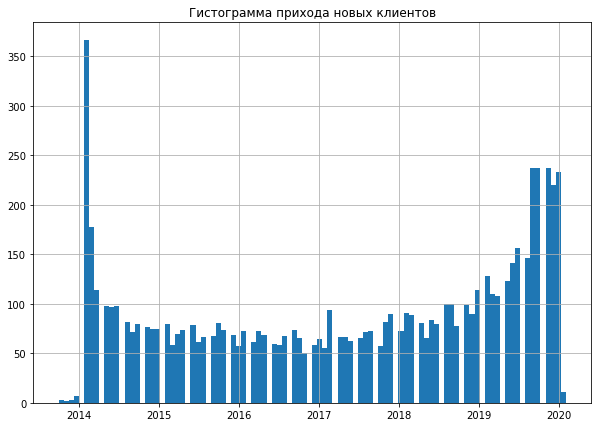

In [97]:
contract['BeginDate'].hist(bins = 100, figsize = (10, 7))
plt.title('Гистограмма прихода новых клиентов')
plt.show()

Исходя из гистограммы времени прихода клиентов в компанию, можем заметить, что:
1. Был огромный всплеск в 2014, но это может быть похоже на то, что компания только открылась, например.
2. С 2015 по 2019 было плато
3. С 2019 заметен возрастающий тренд. Компания начинает привлекать все больше клиентов.

Наше предположение о том, что большая часть клиентов платит не более 100 у.е. можно считать правдоподобным.

In [98]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

В столбце EndDate обнаружено всего 5 уникальных значений. Из того, что имеется можно сделать следующие выводы:
1. Компания имеет значительно больше активных клиентов, чем ушедших. 5174 активных против 1869 ушедших.
2. Клиенты начали уходить только в последние 4 месяца

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>массовый отток))

Text(0.5, 1.0, 'Анализ ушедших клиентов. Гистограмма "старости" ушедшего клиента.')

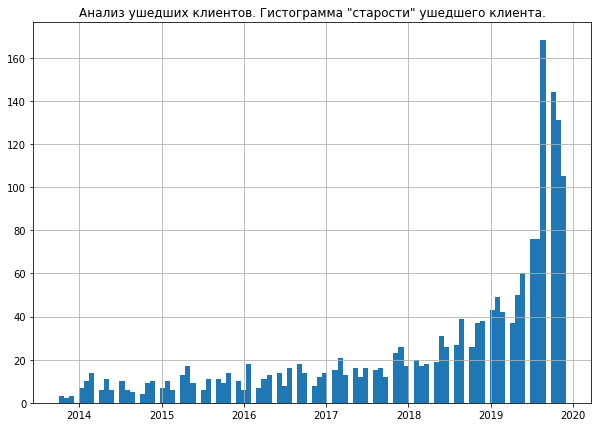

In [99]:
contract[contract['EndDate'] != 'No']['BeginDate'].hist(bins = 100, figsize = (10, 7))
plt.title('Анализ ушедших клиентов. Гистограмма "старости" ушедшего клиента.')

Для компании очень важно понимать портрет тех клиентов, которые уходят. Особенно важно, чтобы те, клиенты, которые с компанией уже давно продолжали оставаться с ней. На этой гистограмме можно посмотреть на распределение клиентов по времени, когда они стали клиентами данной компании. Как видим, больше всего из числа тех, кто перестал быть клиентом, новых клиентов, которые начали пользоваться услугами недавно.

In [100]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

У компании присутствует 3 типа договора. Ежемесячный платеж, годовой и двухгодичный контракт. Наиболее распространен помесячный.

In [101]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Компания принимает 4 вида платежа. Наиболее распространен электронный чек. Меньше всего востребована автоматическая оплата кредитной картой.

Посчитаем, сколько месяцев каждый человек являлся клиентом данной компании. Заодно создадим новый признак для будущей модели.

In [102]:
contract['New_EndDate'] = contract['EndDate']
#Продублируем столбец, чтобы не менять исходные данные

contract.loc[contract['New_EndDate'] == 'No', 'New_EndDate'] = pd.to_datetime('2020-02-01', format = '%Y-%m-%d')
#заменяем в новом столбце все значения, которые == 'No' на дату выгрузк данных

print(contract['New_EndDate'].value_counts()) #проверка

contract['New_EndDate'] = pd.to_datetime(contract['New_EndDate'], format = '%Y-%m-%d')
#меняем тип данных столбца

contract['Days_being_client'] =  ((contract['New_EndDate'] - contract['BeginDate'])/np.timedelta64(1, 'D')).astype('int')
#Считаем разницу в днях между датой, когда человек стал клиентом и датой, когда перестал им быть или же датой выгрузки, если он все еще явлется им

2020-02-01 00:00:00    5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: New_EndDate, dtype: int64


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>интересная мысль с новым признаком.

После того, как получили столбец с количеством месяцев, можно удалить столбец New_EndDate.

In [103]:
contract = contract.drop('New_EndDate', axis = 1)

### Personal

In [104]:
personal.info()
personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [105]:
for el in personal.columns:
    print(personal[el].value_counts())
    print('------------------------------------')

1094-BKOSX    1
8266-VBFQL    1
1958-RNRKS    1
7760-OYPDY    1
3387-VATUS    1
             ..
7083-MIOPC    1
5057-RKGLH    1
1730-VFMWO    1
7136-RVDTZ    1
0018-NYROU    1
Name: customerID, Length: 7043, dtype: int64
------------------------------------
Male      3555
Female    3488
Name: gender, dtype: int64
------------------------------------
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
------------------------------------
No     3641
Yes    3402
Name: Partner, dtype: int64
------------------------------------
No     4933
Yes    2110
Name: Dependents, dtype: int64
------------------------------------


Количество клиентов мужского пола и женского практически равно. Пенсионеры составляют 1/7 часть всех клиентов. Половина всех клиентов имеют партнера. 2/7 клиентов имеют кого то на иждивении. Аномалий не обнаружено.

In [106]:
personal_copy = personal.copy()

personal_copy.loc[personal['gender'] == 'Male', 'gender'] = 0
personal_copy.loc[personal['gender'] == 'Female', 'gender'] = 1

personal_copy.loc[personal['Partner'] == 'No', 'Partner'] = 0
personal_copy.loc[personal['Partner'] == 'Yes', 'Partner'] = 1

personal_copy.loc[personal['Dependents'] == 'No', 'Dependents'] = 0
personal_copy.loc[personal['Dependents'] == 'Yes', 'Dependents'] = 1

In [107]:
print(personal_copy['Partner'].corr(personal_copy['gender']))
print(personal_copy['Partner'].corr(personal_copy['Dependents']))
print(personal_copy['gender'].corr(personal_copy['Dependents']))

0.0018080796617891204
0.4526762829294644
-0.010516611922734096


Для оценки корреляции перевели категориальные столбцы в численные. Есть средняя корреляция между наличием у человека партнера и наличием у них кого то на иждивении. Можно предположить, что эти клиенты, например, родители.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>чётко

### Internet

In [108]:
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [109]:
for el in internet.columns:
    print(internet[el].value_counts())
    print('------------------------------------')

1094-BKOSX    1
8276-MQBYC    1
9839-ETQOE    1
1989-PRJHP    1
9026-RNUJS    1
             ..
5146-CBVOE    1
6627-CFOSN    1
4183-WCSEP    1
4285-GYRQC    1
6210-KBBPI    1
Name: customerID, Length: 5517, dtype: int64
------------------------------------
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
------------------------------------
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
------------------------------------
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
------------------------------------
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
------------------------------------
No     3473
Yes    2044
Name: TechSupport, dtype: int64
------------------------------------
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
------------------------------------
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64
------------------------------------


Большинство клиентов имеют оптоволоконное подключение (3096 из 5517). Посмотрим, отличаются ли подключенные сервисы в зависимости от типа интернета (оптоволокно или DSL).

In [110]:
for el in internet[internet['InternetService'] == 'Fiber optic'].columns:
    print(internet[internet['InternetService'] == 'Fiber optic'][el].value_counts())
    print('------------------------------------')


2250-IVBWA    1
1090-PYKCI    1
9912-GVSEQ    1
0378-CJKPV    1
3707-LRWZD    1
             ..
7562-GSUHK    1
2223-GDSHL    1
7710-JSYOA    1
5887-IKKYO    1
0036-IHMOT    1
Name: customerID, Length: 3096, dtype: int64
------------------------------------
Fiber optic    3096
Name: InternetService, dtype: int64
------------------------------------
No     2257
Yes     839
Name: OnlineSecurity, dtype: int64
------------------------------------
No     1753
Yes    1343
Name: OnlineBackup, dtype: int64
------------------------------------
No     1739
Yes    1357
Name: DeviceProtection, dtype: int64
------------------------------------
No     2230
Yes     866
Name: TechSupport, dtype: int64
------------------------------------
Yes    1750
No     1346
Name: StreamingTV, dtype: int64
------------------------------------
Yes    1751
No     1345
Name: StreamingMovies, dtype: int64
------------------------------------


In [111]:
for el in internet[internet['InternetService'] == 'DSL'].columns:
    print(internet[internet['InternetService'] == 'DSL'][el].value_counts())
    print('------------------------------------')

1094-BKOSX    1
6752-APNJL    1
8348-HFYIV    1
0757-WCUUZ    1
2192-CKRLV    1
             ..
2782-LFZVW    1
4295-YURET    1
6348-SNFUS    1
0248-IPDFW    1
8819-WFGGJ    1
Name: customerID, Length: 2421, dtype: int64
------------------------------------
DSL    2421
Name: InternetService, dtype: int64
------------------------------------
No     1241
Yes    1180
Name: OnlineSecurity, dtype: int64
------------------------------------
No     1335
Yes    1086
Name: OnlineBackup, dtype: int64
------------------------------------
No     1356
Yes    1065
Name: DeviceProtection, dtype: int64
------------------------------------
No     1243
Yes    1178
Name: TechSupport, dtype: int64
------------------------------------
No     1464
Yes     957
Name: StreamingTV, dtype: int64
------------------------------------
No     1440
Yes     981
Name: StreamingMovies, dtype: int64
------------------------------------


Можно сделать следующие выводы:
1. OnlineSecurity. Процент пользователей функцией OnlineSecurity (48.7%) среди пользователей с DSL значительно выше, чем пользователей с оптоволокном (27%).
2. OnlineBackup. Данной функцией пользуются одинаково.
3. DeviceProtection. Данной функцией пользуются одинаково.
4. TechSupport. Данной функцией чаще пользуются пользователи с DSL (присутствует у 48.6% клиентов с DSL, у всего у 27.9% клиентов с оптоволокном). 
5. StreamingTV. Пользователи с DSL: 39.5%. Пользователи с оптоволокном: 56.5%.
6. StreamingMovies. Пользователи с DSL: 40.5%. Пользователи с оптоволокном: 56.5%.

Большинство различий можно связать с особенностями каждого типа подключения. Оптоволокно - более современный тип подключения с более высокими скоростями. Поэтому не удивительно видеть более высокие проценты подписок на стриминговые сервисы по сравнению с пользователя DSL.

### Phone

In [112]:
phone.info()
phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Аномалий не обнурежно. Типа данных столбцов соответствуют их содержанию.

In [113]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

46.7% клиентов имеют возможность ведения параллельных линий во время звонка.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Всё здорово. Замечу только, что такой анализ - это предположение/гипотеза о влиянии факторв на целевую.  И чтобы подтвердить/опровергнуть его - применяют аналитические методы проверки гипотез (спринт 4, например).

## Вывод исследовательского анализа данных

In [114]:
len(contract), len(personal), len(internet), len(phone)

(7043, 7043, 5517, 6361)

Был проанлизирован и изучен каждый документ. На основе данного анализа можно сделать следующие выводы:
1. В таблицах присутствует большое количество разнообразных типов данных. Для дальнейшего построения модели машинного обучение будет необходимо применять кодирование.
2. Присутствует значимый дисбаланс в классах в предсказуемой переменной ```contract['EndDate']```. Поэтому, возможно будет актуально применять инструменты для балансировки (upsampling / downsampling).
3. Был создан один дополнительный признак.
4. Количество строк в таблицах различается. Что говорит о том, что каким то клиентам оказывается не весь пакет услуг, а что то одно (либо интернет, либо телефония).

## Подготовка данных для обучения модели

Попробуем объединить все таблицы, провести кодировку категориальных переменных и обучить модель. Перед объединением добавим бинарные переменные(1;0) в таблицы internet и phone, которые будут выделять тех клиентов, которые пользуется этими сервисами.

In [115]:
internet['internet_client'] = 'Yes'
phone['phone_client'] = 'Yes'

Далее объединим все таблицы в одну.

In [116]:
contract_personal = contract.merge(personal, on = 'customerID')
contract_personal_internet = contract_personal.merge(internet, on = 'customerID', how = 'outer')
full_data = contract_personal_internet.merge(phone, on = 'customerID', how = 'outer')

In [117]:
full_data.isna().sum()

customerID              0
BeginDate               0
EndDate                 0
Type                    0
PaperlessBilling        0
PaymentMethod           0
MonthlyCharges          0
TotalCharges            0
Days_being_client       0
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
InternetService      1526
OnlineSecurity       1526
OnlineBackup         1526
DeviceProtection     1526
TechSupport          1526
StreamingTV          1526
StreamingMovies      1526
internet_client      1526
MultipleLines         682
phone_client          682
dtype: int64

Поскольку таблицы internet и phone имеют разные длины по сравнению с таблицей contract, где содержаться все клиенты, то таблицы internet и phone были присоединины методом outer. Соответственно, у тех клиентов, которые не пользовались интернетом или телефонией данной компании появились пропуски.

In [118]:
full_data = full_data.fillna('None')
full_data.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Days_being_client    0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
internet_client      0
MultipleLines        0
phone_client         0
dtype: int64

Заполняем все пропущенные значения новой категорией 'None'. Итого, на данный момент клиенты делятся на три категории:
1. Yes. Клиент является клиентом компании, пользуется данным сервисом (интернет или телефония) и использует ту или иную технологию внутри выбранного сервиса.
2. No. Клиент не пользуется данным сервисом. Клиент пользуется сервисом, но не выбранной технологией внутри выбранного сервиса.
3. None. Клиент в принципе не использует данный сервис.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Согласен!

Далее закодируем категориальные данные разными кодировщиками, чтобы в дальнейшем оценить эффективность каждого и выбрать наилучший. Однако перед этим избавимся от столбца customerID, поскольку никакой информации о клиенте он в себе не несет, переведем столбец EndDate в бинарную переменную, а также удалим столбец BeginDate, поскольку в сочетании с признаком Months_being_client это может привести к утечки данных.

In [119]:
full_data = full_data.drop(['customerID', 'BeginDate'], axis = 1)

In [120]:
full_data.loc[full_data['EndDate'] != 'No', 'EndDate'] = 1
full_data.loc[full_data['EndDate'] == 'No', 'EndDate'] = 0

In [121]:
columns_numerical = []
for el in full_data.columns:
    if full_data[el].dtype == 'int64' or full_data[el].dtype == 'float64':
        columns_numerical.append(el)
    

Перед кодированием необходимо проверить признаки на наличие мультиколлинераности.

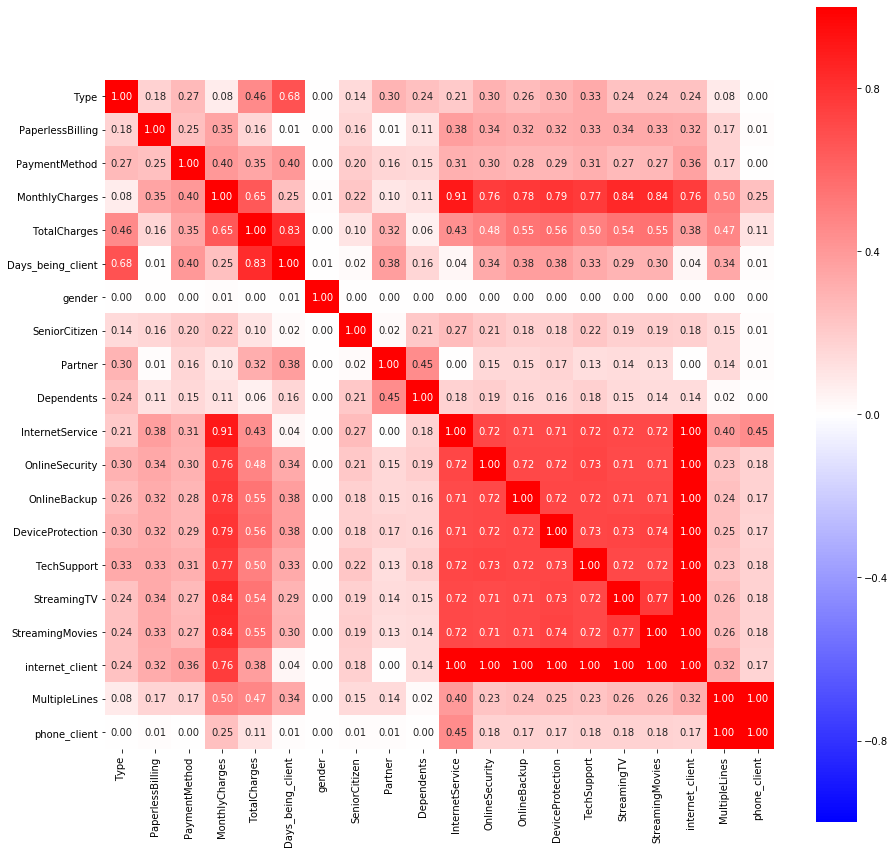

In [122]:
associations(full_data.drop('EndDate', axis = 1), figsize = (15, 15), numerical_columns = columns_numerical, cmap = 'bwr')
plt.show()

Обнаружены сильные корреляции между признаками ( >= 0.89):
1. MonthlyCharges и InternetService
2. MonthlyCharges и InternetService
3. MonthlyCharges и StreamingMovies
4. MonthlyCharges и DeviceProtection

In [36]:
full_data = full_data.drop(['InternetService', 'StreamingTV', 'StreamingMovies', 'DeviceProtection'], axis = 1)

Избавляемся от мультиколлинераности.

### OrdinalEncoder

In [37]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(full_data), columns = full_data.columns)
data_ordinal.info()
data_ordinal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
EndDate              7043 non-null float64
Type                 7043 non-null float64
PaperlessBilling     7043 non-null float64
PaymentMethod        7043 non-null float64
MonthlyCharges       7043 non-null float64
TotalCharges         7043 non-null float64
Days_being_client    7043 non-null float64
gender               7043 non-null float64
SeniorCitizen        7043 non-null float64
Partner              7043 non-null float64
Dependents           7043 non-null float64
OnlineSecurity       7043 non-null float64
OnlineBackup         7043 non-null float64
TechSupport          7043 non-null float64
internet_client      7043 non-null float64
MultipleLines        7043 non-null float64
phone_client         7043 non-null float64
dtypes: float64(17)
memory usage: 935.5 KB


,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Days_being_client,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,TechSupport,internet_client,MultipleLines,phone_client
0,0.0,0.0,1.0,2.0,142.0,74.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,3.0,498.0,3628.0,74.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,3.0,436.0,540.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,266.0,3574.0,96.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0
4,1.0,0.0,1.0,2.0,729.0,678.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,1.0,1.0,3.0,991.0,3704.0,52.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,1.0
7039,0.0,1.0,1.0,1.0,1340.0,6308.0,155.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0
7040,0.0,0.0,1.0,2.0,137.0,1269.0,25.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0
7041,1.0,0.0,1.0,3.0,795.0,1161.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0


### One-Hot Encoding

In [38]:
data_OHE = pd.get_dummies(full_data, drop_first = True)
data_OHE.info()
data_OHE

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
EndDate                                  7043 non-null int64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
Days_being_client                        7043 non-null int64
SeniorCitizen                            7043 non-null int64
Type_One year                            7043 non-null uint8
Type_Two year                            7043 non-null uint8
PaperlessBilling_Yes                     7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check               7043 non-null uint8
gender_Male                              7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
OnlineSecurity_None                

,EndDate,MonthlyCharges,TotalCharges,Days_being_client,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,OnlineSecurity_None,OnlineSecurity_Yes,OnlineBackup_None,OnlineBackup_Yes,TechSupport_None,TechSupport_Yes,internet_client_Yes,MultipleLines_None,MultipleLines_Yes,phone_client_Yes
0,0,29.85,29.85,31,0,0,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0
1,0,56.95,1889.50,1036,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,1,53.85,108.15,61,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,1
3,0,42.30,1840.75,1371,0,1,0,0,0,0,...,0,1,0,0,0,1,1,1,0,0
4,1,70.70,151.65,61,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,730,0,1,0,1,0,0,...,0,1,0,0,0,1,1,0,1,1
7039,0,103.20,7362.90,2191,0,1,0,1,1,0,...,0,0,0,1,0,0,1,0,1,1
7040,0,29.60,346.45,337,0,0,0,1,0,1,...,0,1,0,0,0,0,1,1,0,0
7041,1,74.40,306.60,123,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,1


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
👍👍

### Подготовка обучающего и тестового датасетов

In [39]:
#OrdinalEncoder
features_ordinal = data_ordinal.drop(['EndDate'], axis = 1)
target_ordinal = data_ordinal['EndDate']

features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test = train_test_split(features_ordinal, target_ordinal, test_size = .2, random_state = 123)


#OHE
features_OHE = data_OHE.drop(['EndDate'], axis = 1)
target_OHE = data_OHE['EndDate']

features_OHE_train, features_OHE_test, target_OHE_train, target_OHE_test = train_test_split(features_OHE, target_OHE, test_size = .2, random_state = 123)


### Дисбаланс классов

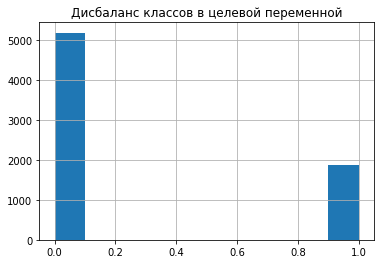

In [40]:
full_data['EndDate'].hist()
plt.title('Дисбаланс классов в целевой переменной')
plt.show()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>да, разбаланс виден. Чаще всего границу принимают на уровне 0.25-0.30 , всё, что ниже - однозначно в балансировку). А так - на усмотрение аналитика.

Для борьбы с дисбалансом попробуем следующие техники:
1. Upsampling
2. Downsampling
3. Соответствующие гиперпараметры у моделей

### Upsampling

In [41]:
full_data['EndDate'].value_counts()

0    5174
1    1869
Name: EndDate, dtype: int64

In [42]:
ones_multiplier = round(len(full_data) // len(full_data.loc[full_data['EndDate'] == 1, 'EndDate']), 1)
ones_multiplier

3

Для уравновешивания классов необходимо домножить класс с таргетом "1" на 3.

In [43]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [44]:
features_train_upsampled_OHE, target_train_upsampled_OHE = upsample(features_OHE_train, target_OHE_train, 4)

len(features_train_upsampled_OHE), len(target_train_upsampled_OHE)#, len(features_test_upsampled_OHE), len(target_test_upsampled_OHE)

(10059, 10059)

In [45]:
features_train_upsampled_ordinal, target_train_upsampled_ordinal = upsample(features_ordinal_train, target_ordinal_train, 4)

len(features_train_upsampled_ordinal), len(target_train_upsampled_ordinal)#, len(features_test_upsampled_ordinal), len(target_test_upsampled_ordinal)

(10059, 10059)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>ОК, балансируем только трайн.

### Downsampling

In [46]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [47]:
features_train_downsampled_OHE, target_train_downsampled_OHE = downsample(features_OHE_train, target_OHE_train, .3)

In [48]:
features_train_downsampled_ordinal, target_train_downsampled_ordinal = downsample(features_ordinal_train, target_ordinal_train, .3)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>тааааак, самое трудное позади, начинается самое захватывающее))

### Обучение моделей
После того, как была проведена предобрабокта данных можно перейти к обучению моделей. Для обучения возьмем следующие модели:
1. Random forest
2. Lgbm
3. XGBoost
4. CatBoost
5. Logistic Regression

#### Random forest

max_depth = 0
best_est = 0
best_model = None
S = 0
for est in range (70, 150):
    for depth in range (7, 12):
        model_balanced = RandomForestClassifier(random_state = 1, n_estimators = est, max_depth = depth)
        model_balanced.fit(features_train_upsampled_OHE, target_train_upsampled_OHE)
        predictions = model_balanced.predict(features_OHE_test)
        probabilities_RF = model_balanced.predict_proba(features_OHE_test)
        probabilities_one_RF = probabilities_RF[:, 1]
        s = roc_auc_score(target_OHE_test, probabilities_one_RF)
        if s > S:
            S = s
            max_depth = depth
            best_model = model_balanced
            best_est = est
    
print('max depth', max_depth)
print('best_est:', best_est)
print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc_score(target_OHE_test, probabilities_one_RF)))

In [49]:
def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state = 1, n_estimators = 99, max_depth = 8)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [50]:
rf_up_OHE = random_forest(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.86
Accuracy: 0.73


In [51]:
rf_ORD = random_forest(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Площадь под ROC-кривой: 0.87
Accuracy: 0.82


In [52]:
rf_up_ORD = random_forest(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.87
Accuracy: 0.74


In [53]:
rf_down_OHE = random_forest(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.86
Accuracy: 0.74


In [54]:
rf_down_ORD = random_forest(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.86
Accuracy: 0.75


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>чётко)

#### Lgbm

In [55]:
def lgbm(X_train, X_test, y_train, y_test):
    model = lgb.LGBMClassifier()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [56]:
lgbm_up_OHE = lgbm(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.91
Accuracy: 0.82


In [57]:
lgbm_ORD = lgbm(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Площадь под ROC-кривой: 0.90
Accuracy: 0.85


In [58]:
lgbm_up_ORD = lgbm(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.91
Accuracy: 0.82


In [59]:
lgbm_down_OHE = lgbm(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)


Площадь под ROC-кривой: 0.88
Accuracy: 0.79


In [60]:
lgbm_down_ORD = lgbm(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.88
Accuracy: 0.78


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>движемся вверх по метрике))

#### XGBoost

In [61]:
def XGBoost_model(X_train, X_test, y_train, y_test):
    model = XGBClassifier(iterations=100, verbose = 0)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [62]:
XGB_up_OHE = XGBoost_model(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)


Площадь под ROC-кривой: 0.88
Accuracy: 0.75


In [63]:
XGB_ORD = XGBoost_model(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)


Площадь под ROC-кривой: 0.88
Accuracy: 0.83


In [64]:
XGB_up_ORD = XGBoost_model(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)


Площадь под ROC-кривой: 0.89
Accuracy: 0.74


In [65]:
XGB_down_OHE = XGBoost_model(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)


Площадь под ROC-кривой: 0.88
Accuracy: 0.76


In [66]:
XGB_down_ORD = XGBoost_model(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.87
Accuracy: 0.75


#### CatBoost

In [67]:
def CatBoost_model(X_train, X_test, y_train, y_test):
    model = CatBoostClassifier(eval_metric='AUC', iterations=500, verbose = 500)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [68]:
cb_up_OHE = CatBoost_model(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Learning rate set to 0.059712
0:	total: 79.2ms	remaining: 39.5s
499:	total: 51s	remaining: 0us
Площадь под ROC-кривой: 0.91
Accuracy: 0.83


In [69]:
cb_ORD = CatBoost_model(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Learning rate set to 0.050678
0:	total: 14.4ms	remaining: 7.19s
499:	total: 17.3s	remaining: 0us
Площадь под ROC-кривой: 0.91
Accuracy: 0.86


In [70]:
cb_up_ORD = CatBoost_model(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)


Learning rate set to 0.059712
0:	total: 31.7ms	remaining: 15.8s
499:	total: 54.1s	remaining: 0us
Площадь под ROC-кривой: 0.91
Accuracy: 0.83


In [71]:
cb_down_OHE = CatBoost_model(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)

Learning rate set to 0.041253
0:	total: 8.94ms	remaining: 4.46s
499:	total: 13.5s	remaining: 0us
Площадь под ROC-кривой: 0.89
Accuracy: 0.78


In [72]:
cb_down_ORD = CatBoost_model(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Learning rate set to 0.041253
0:	total: 3.11ms	remaining: 1.55s
499:	total: 13.7s	remaining: 0us
Площадь под ROC-кривой: 0.88
Accuracy: 0.78


#### Logistic regression

In [73]:
def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [74]:
lg_up_OHE = logistic_regression(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.76


In [75]:
lg_ORD = logistic_regression(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.74


In [76]:
lg_up_ORD = logistic_regression(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.74


In [77]:
lg_dwon_OHE = logistic_regression(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.76


In [78]:
lg_dwon_ORD = logistic_regression(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.75


## Выводы

In [79]:
columns = ['AUC_ROC', 'Accuracy']

rf_ACC = rf_up_OHE[0], rf_ORD[0], rf_up_ORD[0], rf_down_OHE[0], rf_down_ORD[0]
rf_AUC = rf_up_OHE[1], rf_ORD[1], rf_up_ORD[1], rf_down_OHE[1], rf_down_ORD[1]

lgbm_ACC = lgbm_up_OHE[0], lgbm_ORD[0], lgbm_up_ORD[0], lgbm_down_OHE[0], lgbm_down_ORD[0]
lgbm_AUC = lgbm_up_OHE[1], lgbm_ORD[1], lgbm_up_ORD[1], lgbm_down_OHE[1], lgbm_down_ORD[1]

xgboost_ACC = XGB_up_OHE[0], XGB_ORD[0], XGB_up_ORD[0], XGB_down_OHE[0], XGB_down_ORD[0]
xgboost_AUC = XGB_up_OHE[1], XGB_ORD[1], XGB_up_ORD[1], XGB_down_OHE[1], XGB_down_ORD[1]

cb_ACC = cb_up_OHE[0], cb_ORD[0], cb_up_ORD[0], cb_down_OHE[0], cb_down_ORD[0]
cb_AUC = cb_up_OHE[1], cb_ORD[1], cb_up_ORD[1], cb_down_OHE[1], cb_down_ORD[1]

lr_ACC = lg_up_OHE[0], lg_ORD[0], lg_up_ORD[0], lg_dwon_OHE[0], lg_dwon_ORD[0]
lr_AUC = lg_up_OHE[1], lg_ORD[1], lg_up_ORD[1], lg_dwon_OHE[1], lg_dwon_ORD[1]

In [80]:
accuracy = list(sum([rf_ACC, lgbm_ACC, xgboost_ACC, cb_ACC, lr_ACC], ()))
auc_roc = list(sum([rf_AUC, lgbm_AUC, xgboost_AUC, cb_AUC, lr_AUC], ()))

In [81]:
results = pd.DataFrame(data = accuracy, columns = ['Accuracy'])
results['AUC_ROC'] = auc_roc
index = ['rf_up_OHE', 'rf_ORD', 'rf_up_ORD', 'rf_down_OHE', 'rf_down_ORD', 'lgbm_up_OHE', 'lgbm_ORD', 'lgbm_up_ORD', \
         'lgbm_down_OHE', 'lgbm_down_ORD', 'XGB_up_OHE', 'XGB_ORD', 'XGB_up_ORD', 'XGB_down_OHE', 'XGB_down_ORD', \
         'cb_up_OHE', 'cb_ORD', 'cb_up_ORD', 'cb_down_OHE', 'cb_down_ORD', 'lg_up_OHE', 'lg_ORD', 'lg_up_ORD', \
         'lg_dwon_OHE', 'lg_dwon_ORD']
results.index = index

In [82]:
results.sort_values('AUC_ROC', ascending = False)

,Accuracy,AUC_ROC
cb_ORD,0.861,0.915
lgbm_up_ORD,0.818,0.911
cb_up_ORD,0.828,0.907
lgbm_up_OHE,0.823,0.907
cb_up_OHE,0.825,0.905
lgbm_ORD,0.849,0.902
XGB_up_ORD,0.737,0.887
cb_down_OHE,0.784,0.887
lgbm_down_OHE,0.789,0.885
lgbm_down_ORD,0.779,0.884


За основу были взяты 5 моделей (Random forest, Lgbm, XGBoost, CatBoost, Logistic regression). Затем рассматривались показатели каждой модели в разных условиях:
1. Менялся кодировщик (OHE, Ordinal)
2. Менялся способ борьбы с дисбалансом (Upsampling, Downsampling)
3. Оригинальные данные без борьбы с дисбалансом

В качестве основной целевой метрики использовался ROC AUC и в качестве дополнительной accuracy. Итого, получилось 25 моделей. Наилучший основной скор получилось достичь модели CatBoost без работы с дисбалансом и ordinal кодировщиком (0.915), второе место по скору заняла модель lgbm с ordinal encoder и upsampling (0.911). Рассмотрим, подробнее эти 2 модели.

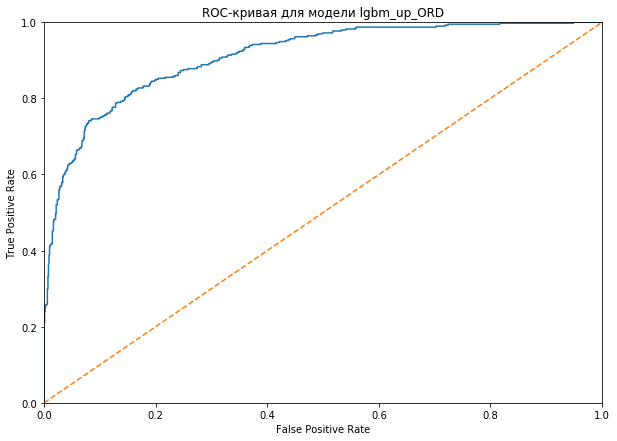

Площадь под ROC-кривой: 0.91


In [83]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(features_train_upsampled_ordinal, target_train_upsampled_ordinal)
    
probabilities = model_lgb.predict_proba(features_ordinal_test)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(target_ordinal_test, probabilities_one)

plt.figure(figsize = (10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для модели lgbm_up_ORD")
plt.show()

print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc_score(target_ordinal_test, probabilities_one)))

#features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test

,0
Days_being_client,1177
MonthlyCharges,603
TotalCharges,485
PaymentMethod,141
Type,90
gender,74
PaperlessBilling,63
TechSupport,62
OnlineSecurity,61
Partner,56


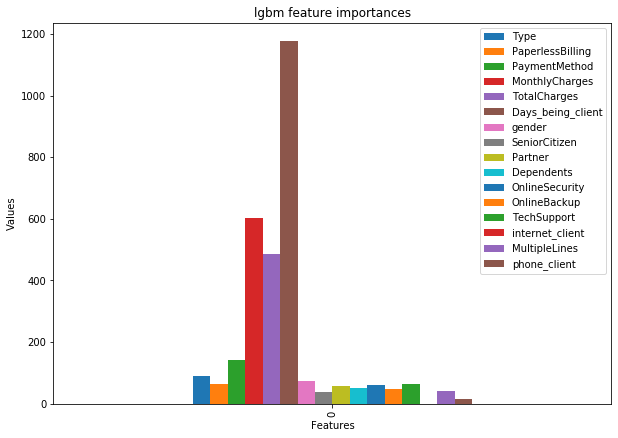

In [84]:
#Определение значимости признаков
lgbm_importances = pd.DataFrame(model_lgb.feature_importances_).T
lgbm_importances.columns = features_train_upsampled_ordinal.columns
lgbm_importances.plot(kind = 'bar', figsize = (10, 7))
plt.ylabel('Values')
plt.xlabel('Features')
plt.title('lgbm feature importances')
display(lgbm_importances.T.sort_values(0, ascending = False))

Из графика можно выделить 3 наиболее значимых признака для модели (идут по убыванию значимости):
1. Days_being_client
2. MonthlyCharges
3. TotalCharges

Отсюда можно сделать логичный вывод: чем дольше человек является клиентом сервиса, и чем больше денег отдает за пользование сервисом, тем больше его лояльность данному сервису, и тем меньше желание его менять. Все остальные признаки находятся примерно на одном уровне значимости. Значимость признаков phone_client и internet_client вообще околонулевая, что говорит о том, что от них можно избавиться без влияния на качество модели.

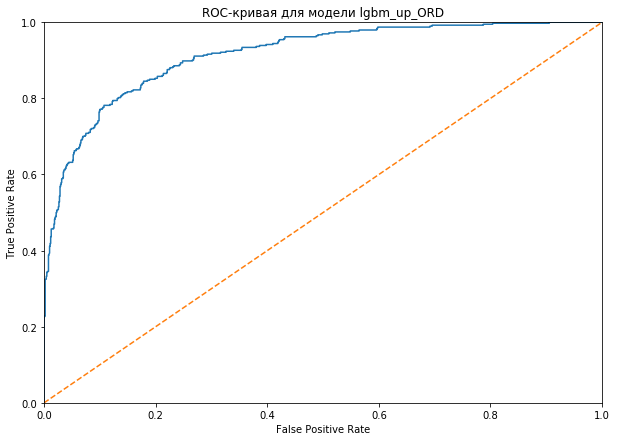

Площадь под ROC-кривой: 0.91


In [85]:
model_cb = CatBoostClassifier(eval_metric='AUC', iterations=500, verbose = 0)
model_cb.fit(features_ordinal_train, target_ordinal_train)

probabilities = model_cb.predict_proba(features_ordinal_test)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(target_ordinal_test, probabilities_one)

plt.figure(figsize = (10, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для модели lgbm_up_ORD")
plt.show()

print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc_score(target_ordinal_test, probabilities_one)))

,0
Days_being_client,43.548215
MonthlyCharges,11.887352
Type,9.674123
TotalCharges,9.216241
PaymentMethod,4.942639
OnlineSecurity,3.590907
TechSupport,3.120808
PaperlessBilling,2.366203
MultipleLines,2.245070
OnlineBackup,2.230119


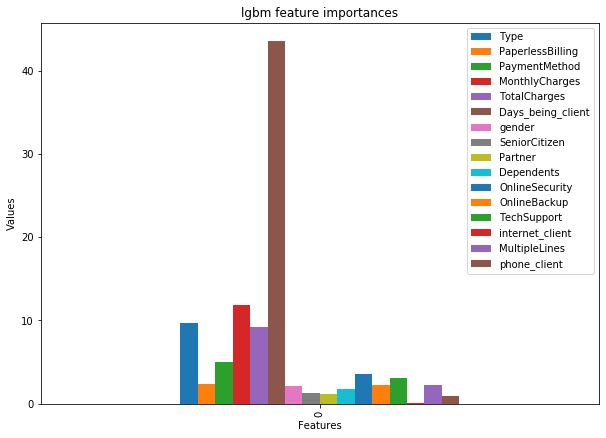

In [86]:
#Определение значимости признаков
cb_importances = pd.DataFrame(model_cb.feature_importances_).T
cb_importances.columns = features_ordinal_train.columns
cb_importances.plot(kind = 'bar', figsize = (10, 7))
plt.ylabel('Values')
plt.xlabel('Features')
plt.title('lgbm feature importances')
display(cb_importances.T.sort_values(0, ascending = False))

У модели CatBoost первые три места занимают те же признаки, что и у lgbm, однако для catboost столь же значимым стал и признак type. Его включение подпадает под ту же логику, которая была описана выше. Если клиент заключает договор сразу на длительный срок, то, скорее всего, это означает, что с сервисом он уже познакомился и он его полностью устраивает, следовательно, вероятность того, что клиент с долгосрочный договором передумает и решить перестать пользоваться услугами данной компании значительно меньше, чем у клиента с помесячной оплатой.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ОК, Егор, скажу, что уверенная работа, на мой взгляд)<br>
Обработка данных, размышления над факторами, многогранная модельная работа, конечные результаты - многое удалось как надо<br> 
А что совсем хорошо, так это то, что не стал гнаться за точностью любой ценой, даже ценой наружения бизнес-логики. (это я про даты-признаки, многие их вставляют...)<br>

Прежде, чем идти дальше, напомню из прошлых наших общений основные моменты, которые бы мне хотелось зафиксировать, как важные для момделирования (что-то ты и так хорошо используешь):<br>   
1) F1, Акураси и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" 
    
2) При анализе факторов влияния (их зависиомть между собой и на целевую) происходит по одному из трёх алгоритмов, исходя из типа шкалы. Могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
Это я к тому разделу, который посвящён анализу данных. Там ты сделал интересные предположения и чтобы их доказать, стои проверить аналитически. Вот как раз те методы проверки гипотез, что выше написал.<br>
    
3) Алгоритм нахождения модели может быть таким:<br>
- изучаем проблематику бизнеса и самой темы (в данном случае отток). Пытаемся понять суть явления.<br>
- генерируем разные факторы влияния - любые.<br>
- дизайнируем (прикидываем модели) какие методы решения есть, чтобы решить проблему.<br>
- Смотрим, какие данные и в какой шкале есть. Что нужно ещё, что применить выбранный метод.<br>
- Оцениваем мультиколлинеарность.<br>
- строим модели и анализируем те фактры, какие сгенерировали ранее.<br>
- Думаем над тем, какие причины (факторы) могут ещё влиять на отток.<br>
- если после нескольких итераций точность "замирает" - значит достигли потолка)<br>
 
4) Проведение анализа важности факторов с помощью команды feature_importances_ (+графический анализ). Отличная вещь намечается: высока я метрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала. Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют на уход клиента.

<font color='red'>
Есть пару-тройку вопросов для дополнений:<br>
1)При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее)<br><br>
2) Будет здорово, если построишь график важности факторов.
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Просто эти два пункта - важный момент в алгоритме моделирования. И хотелось, чтобы они у тебя остались в финале.<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.

Спасибо большое за развернутый комментарий в конце!:) Хотелось бы уточнить пару моментов:
1. Не могли бы поподробнее расписать 1 пункт про взаомодействие метрик. На данный момент имеется лишь теоретическое представление о них. Как именно через даннеы метрики ожно выйти на практические советы для бизнеса?
2. Для оценки мультиколлинераности нашел стороннюю библиотеку, которая согласно описанию, автоматически определяет тип данных и соответствующий ему способ подсчета корреляции. Насколько можно ей доверять и как вообще оценивать "адекватность" таких сторонних небольших библиотек? На ум приходит только доскональное изучение документации, но может быть, есть способ быстрее?

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
Привет Егор.<br>
ОК, спасибо за доработки)<br>
    
1) Да, я тут писал о том, что конечно же должна быть экономическая целесообразность разработываемого решения. Любая моедль - это помощь по оптимизации некоего процесса. Вот данная модель - это, скорее всего, для отдела продаж подсказка того, как общаться с тем или иным клиентом. Т.е. данное решение позволит вовпремя реагировать на поведение клиента и кпредить его уход. И, с другой стороны, данное решение позволит оптимизировать (если его доработать дальше) затраты на рекламные каналы. Например, если вероятность оттока клиента высока, то с ним работаем по каналу "звонок". Это самый дорогой, но наиболее действенный. Если вероятность ухода не высокая - можем просто смс-ку отправить. Это подешевле.<br>
    
    
А теперь, Как понять - эффективна ли модель.  Здесь помогут метрики полноты и точности.<br>
Предположим, у нас есть отток клиента. У ная финансовый отдел посчитал: уход одного клиента стоит нам 100 рублей. СТОимость рекламного канала - 30 рублей на клиента.<br>
Теперь, наша модель: мы прогнозируем отток. и у нас есть два типа ошибок: мы подумаем, что клиент хочет уйти, а на самом деле он никуда не собирался. И - мы подумаем, что клиент никуда не собирается, а он взял и ушёл.<br>
Какую ошибку минимизировать нам выгоднее с позиции экономики? Тут надо считать. Предположим, что по первой ошибке мы не угадываем 20 человек, по второй ошибке мы не угадываем 30 человек. Что это в деньгах? В перврм случае (мы пользовались рекламным каналом, а этого можно было и не делать) - потратили зря 30 рублей * 20 = 600 рублей. Во втором случае: ничего не делали и потеряли 100*30=3000 рублей. По такой логике, можно построить равновесную финансовую кривую, по которой будет понятно где для нас лучший балланс ошибок. Примерно так. Тут, пока может быть не совсем понятно (это нормально. Когда мы такую штуку для банка разрабатывали, то на презентации тоже долго с "раскуривали" ). Просто надо сесть в экселе и по-упражняться в расчётах....А потом, посчитав выгоду работы модели за год, можно сравниваеть её со стоимостью разработки и поддержки модельного решения.<br><br>
2) Точно, тут надо убедиться самому в правильности расчётов. Я поступаю так: В этой сфере я давно и рагьше работал с такимипакетами как Statistica, SPSS, Minitab и точно знаю, что там многоеееее верно считает - уже проверял. Поэтому сейчас часто проверяю библиотеки питона с расчётами пакетов выше)))) <br>
    
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br>